so making sense, i wont be trading on an option contract unless it is in the week of its expiration basically if the chart data i have is till thursday then i wont be taking any buy signals on that chart before Friday of last week as i would have been trading on the chart of previous expiry
so i think its best to eliminate all signals before that time period basically t-5 days

Hence the best possible target and stoploss ration should be calculated accordingly

Processing NSE_NIFTY240620C23400, 15.csv in NIFTY...
Processing NSE_NIFTY240620C23500, 15.csv in NIFTY...
Processing NSE_NIFTY240620C23550, 15.csv in NIFTY...
Processing NSE_NIFTY240620C23600, 15.csv in NIFTY...
Processing NSE_NIFTY240620P23400, 15.csv in NIFTY...
Processing NSE_NIFTY240620P23500, 15.csv in NIFTY...
Processing NSE_NIFTY240620P23550, 15.csv in NIFTY...
Processing NSE_NIFTY240620P23600, 15.csv in NIFTY...


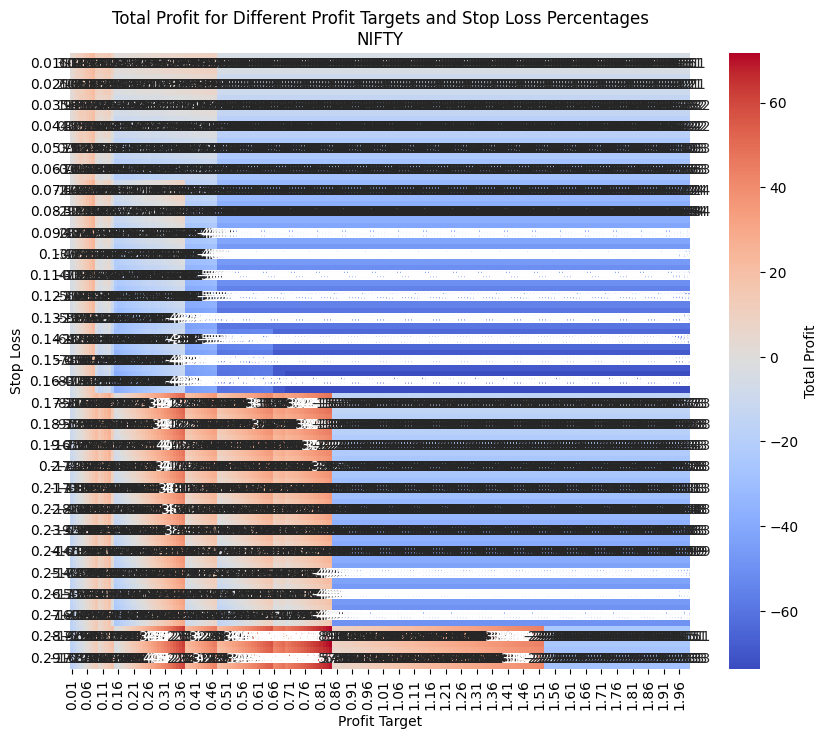

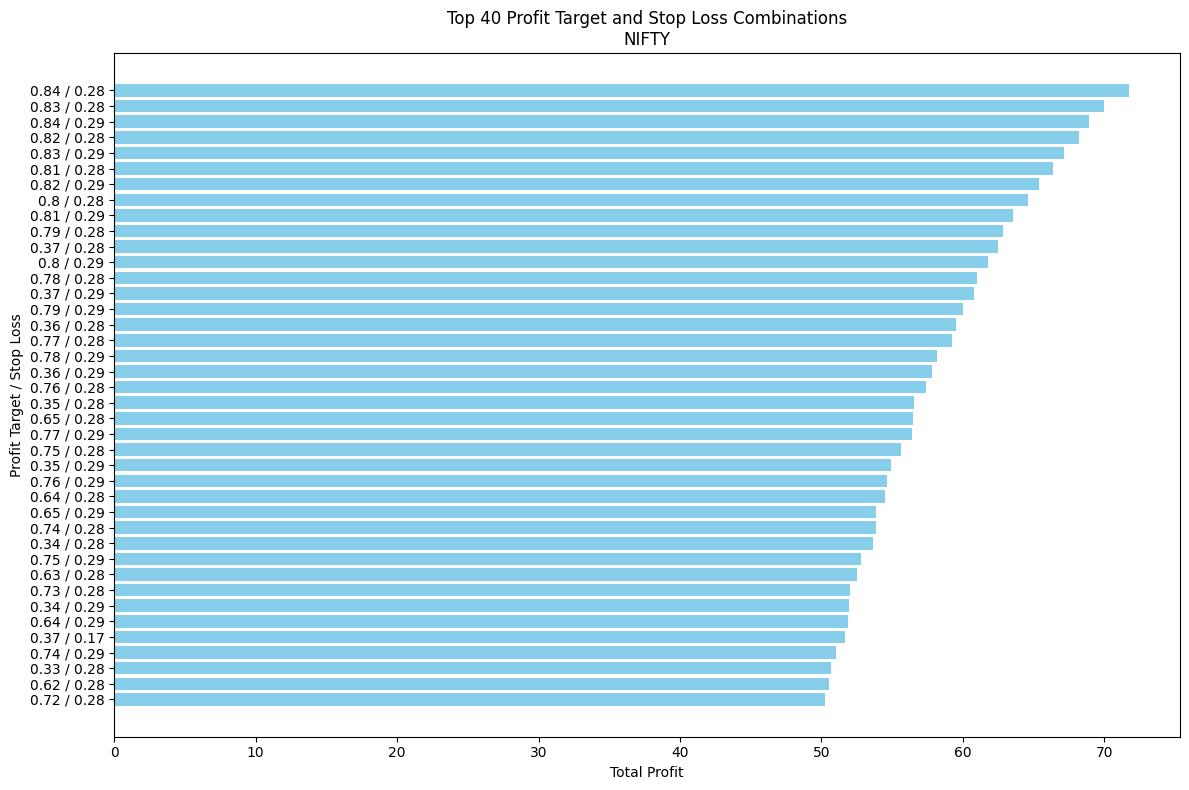

Processing NSE_BANKNIFTY240619C50400, 15.csv in BANKNIFTY...
Processing NSE_BANKNIFTY240619C50500, 15.csv in BANKNIFTY...
Processing NSE_BANKNIFTY240619C50600, 15.csv in BANKNIFTY...
Processing NSE_BANKNIFTY240619P50400, 15.csv in BANKNIFTY...
Processing NSE_BANKNIFTY240619P50500, 15.csv in BANKNIFTY...
Processing NSE_BANKNIFTY240619P50600, 15.csv in BANKNIFTY...


C:\temp\ipykernel_9944\3864350256.py:139: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_trade_results = pd.concat(trade_results_combined, ignore_index=True)
C:\temp\ipykernel_9944\3864350256.py:140: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_all_results = pd.concat(all_combined_results, ignore_index=True)


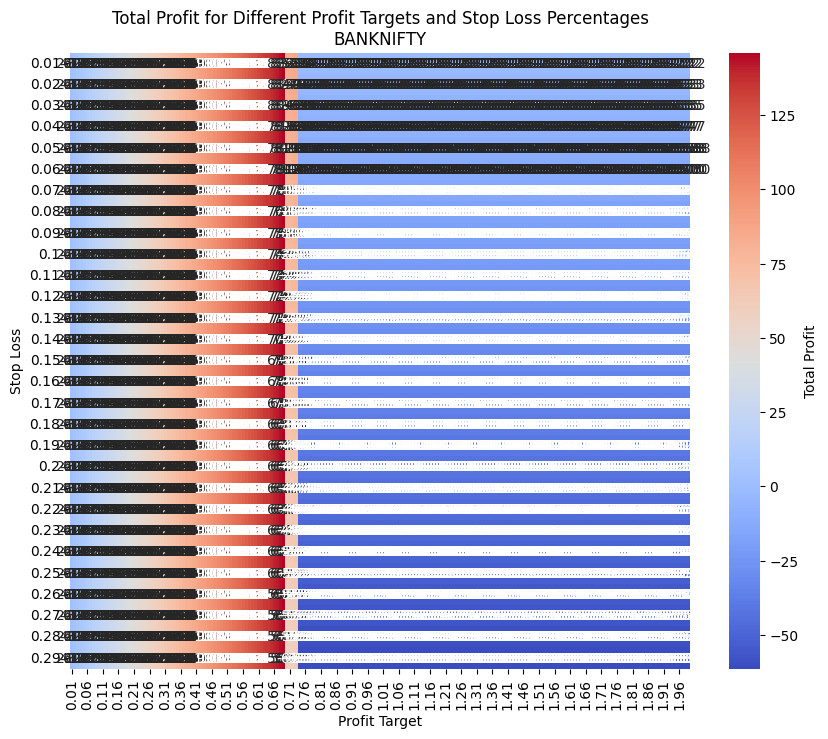

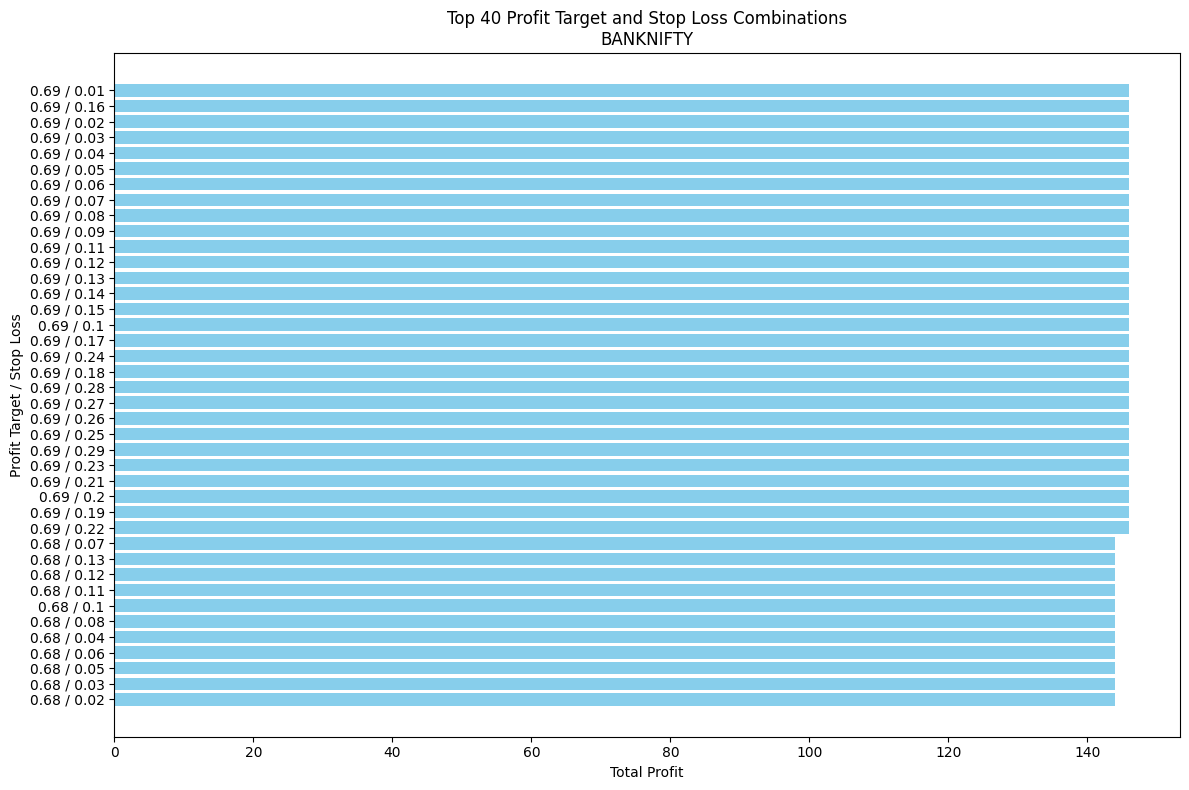

Analysis complete.


In [20]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to filter buy signals from the 15-minute chart data
def filter_signals(data):
    buy_signals = data[(data['Original Buy Signal'] == True) & (data['Short Signal'] == False)]
    return buy_signals

# Function to simulate day trades
def simulate_day_trades(buy_signals, minute_data, profit_target=0.02, stop_loss=0.01, min_stop_loss=0.005):
    results = []
    for index, buy_signal in buy_signals.iterrows():
        entry_price = buy_signal['close']
        entry_time = buy_signal['time'] + 900  # Add 15 minutes to the buy signal time to get the entry time
        profit_price = entry_price * (1 + profit_target)
        stop_price = entry_price * (1 - max(stop_loss, min_stop_loss))  # Ensure stop loss is at least min_stop_loss
        
        trade_result = {
            'signal_time': buy_signal['time'],
            'entry_time': entry_time,
            'entry_price': entry_price,
            'exit_time': None,
            'exit_price': None,
            'profit': None
        }
        
        # Filter subsequent data for the same day only
        trade_date = pd.to_datetime(entry_time, unit='s').date()
        subsequent_data = minute_data[(minute_data['time'] > entry_time) & 
                                      (pd.to_datetime(minute_data['time'], unit='s').dt.date == trade_date)]
        
        for _, row in subsequent_data.iterrows():
            if row['high'] >= profit_price:
                trade_result['exit_time'] = row['time']
                trade_result['exit_price'] = profit_price
                trade_result['profit'] = profit_price - entry_price
                break
            if row['low'] <= stop_price:
                trade_result['exit_time'] = row['time']
                trade_result['exit_price'] = stop_price
                trade_result['profit'] = stop_price - entry_price
                break
        else:
            # If no target or stop loss hit, exit at the last price of the day
            if not subsequent_data.empty:
                last_row = subsequent_data.iloc[-1]
                trade_result['exit_time'] = last_row['time']
                trade_result['exit_price'] = last_row['close']
                trade_result['profit'] = last_row['close'] - entry_price
        
        results.append(trade_result)
    
    return pd.DataFrame(results).dropna(subset=['entry_price'])

# Function to analyze profit and stop loss percentages
def analyze_profit_and_stop_loss(buy_signals, minute_data, profit_percentages, stop_loss_percentages, min_stop_loss=0.005):
    analysis_results = []
    finalresults = []
    for profit_target in profit_percentages:
        for stop_loss in stop_loss_percentages:
            trade_results = simulate_day_trades(buy_signals, minute_data, profit_target, stop_loss, min_stop_loss)
            total_profit = trade_results['profit'].sum()
            analysis_results.append((profit_target, stop_loss, total_profit))
            finalresults.append(trade_results)
    # Combine all trade results into a single DataFrame
    combined_trade_results = pd.concat(finalresults, ignore_index=True)
    return pd.DataFrame(analysis_results, columns=['Profit Target', 'Stop Loss', 'Total Profit']), combined_trade_results

# Define profit percentages and stop loss percentages to analyze
profit_percentages = [i/100 for i in range(1, 200)]
stop_loss_percentages = [i/100 for i in range(1, 30)]

# Directories containing the data
directories = ['June 2024/NIFTY', 'June 2024/BANKNIFTY']

# Function to check if the date is within the week of expiration
def is_within_expiry_week(expiry_date, timestamp, folder_name, days_before_expiry=5):
    # Assuming the date is the 7th to 12th characters in the string
    if folder_name == 'NIFTY':
        date_part = expiry_date[9:15]
    if folder_name == 'BANKNIFTY':
        date_part = expiry_date[13:19]
    
    expiry_datetime = pd.to_datetime(date_part, format='%y%m%d')
    signal_datetime = pd.to_datetime(timestamp, unit='s')
    return (expiry_datetime - signal_datetime).days <= days_before_expiry

# Process each directory
for directory in directories:
    pnl_results = []
    trade_results_combined = []
    all_combined_results = []
    folder_name = os.path.basename(directory)
    for subdir, _, files in os.walk(directory):
        if subdir == directory:
            continue  # Skip the top-level directory itself
        for filename in files:
            if ', 15.csv' in filename:
                minute_15_path = os.path.join(subdir, filename)
                minute_1_path = minute_15_path.replace(', 15.csv', ', 1.csv')
                
                if os.path.exists(minute_1_path):
                    print(f"Processing {filename} in {folder_name}...")
                    
                    # Extract expiry date from filename
                    expiry_date = filename.split(' ')[0].split(',')[0]
                    
                    # Load the CSV files
                    minute_data_15 = pd.read_csv(minute_15_path)
                    minute_data_1 = pd.read_csv(minute_1_path)
                    
                    # Filter buy signals
                    buy_signals = filter_signals(minute_data_15)
                    
                    # Filter signals to only include those within the expiry week
                    buy_signals = buy_signals[buy_signals['time'].apply(lambda x: is_within_expiry_week(expiry_date, x, folder_name))]
                    
                    # Perform the analysis
                    analysis_results, trade_results = analyze_profit_and_stop_loss(buy_signals, minute_data_1, profit_percentages, stop_loss_percentages)
                    
                    # Merge buy signals with trade results
                    combined_results = pd.merge(buy_signals, trade_results, left_on='time', right_on='signal_time', how='inner')
                    
                    # Merge the 15-minute chart data with combined results
                    combined_results = pd.merge(combined_results, minute_data_15, left_on='time', right_on='time', suffixes=('_buy', '_original'))
                   
                    all_combined_results.append(combined_results)
                    
                    # Append to combined results
                    pnl_results.append(analysis_results)
                    trade_results_combined.append(trade_results)
    
    # Combine all results for the folder
    combined_pnl_results = pd.concat(pnl_results, ignore_index=True)
    # Aggregate total profits for the same combinations
    combined_pnl_results = combined_pnl_results.groupby(['Profit Target', 'Stop Loss'], as_index=False)['Total Profit'].sum()
    combined_trade_results = pd.concat(trade_results_combined, ignore_index=True)
    combined_all_results = pd.concat(all_combined_results, ignore_index=True)
    
    # Save the results to CSV files
    combined_pnl_results.to_csv(f'Outputs/DayTrade/ExpiryWeek/{folder_name}_pnl_analysis.csv', index=False)
    combined_trade_results.to_csv(f'Outputs/DayTrade/ExpiryWeek/{folder_name}_trade_results.csv', index=False)
    combined_all_results.to_csv(f'Outputs/DayTrade/ExpiryWeek/{folder_name}_all_combined_results.csv', index=False)
    
    # Find the best combination of profit target and stop loss
    best_combination = combined_pnl_results.loc[combined_pnl_results['Total Profit'].idxmax()]
    
    # Save the best combination
    best_combination_df = pd.DataFrame([best_combination])
    best_combination_df.to_csv(f'Outputs/DayTrade/ExpiryWeek/{folder_name}_best_combination.csv', index=False)
    
    # Save the top 40 combinations
    top_40_combinations = combined_pnl_results.sort_values(by='Total Profit', ascending=False).head(40)
    top_40_combinations.to_csv(f'Outputs/DayTrade/ExpiryWeek/{folder_name}_top_40_combinations.csv', index=False)
    
    # Plot the heatmap for better visualization
    pivot_table = combined_pnl_results.pivot(index="Stop Loss", columns="Profit Target", values="Total Profit")
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Total Profit'})
    plt.title(f"Total Profit for Different Profit Targets and Stop Loss Percentages\n{folder_name}")
    plt.xlabel("Profit Target")
    plt.ylabel("Stop Loss")
    plt.show()
    plt.savefig(f'Outputs/DayTrade/ExpiryWeek/{folder_name}_heatmap.png')
    plt.close()

    # Plot the bar chart for top 40 combinations
    plt.figure(figsize=(12, 8))
    plt.barh(top_40_combinations['Profit Target'].astype(str) + " / " + top_40_combinations['Stop Loss'].astype(str),
             top_40_combinations['Total Profit'], color='skyblue')
    plt.xlabel('Total Profit')
    plt.ylabel('Profit Target / Stop Loss')
    plt.title(f'Top 40 Profit Target and Stop Loss Combinations\n{folder_name}')
    plt.gca().invert_yaxis()  # To display the highest
    plt.tight_layout()
    plt.show()
    plt.savefig(f'Outputs/DayTrade/ExpiryWeek/{folder_name}_top_40_combinations.png')
    plt.close()

print("Analysis complete.")
